# Download Training data

In [6]:
import requests, zipfile, io
import pandas as pd

url = 'https://www.kaggle.com/api/v1/datasets/download/prishasawhney/mushroom-dataset?datasetVersionNumber=1'
r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    with z.open('mushroom_cleaned.csv') as f:
        df = pd.read_csv(f)

In [8]:
import s3fs

s3 = s3fs.S3FileSystem()
s3.mkdir("traindata")

In [11]:
df.to_parquet('s3://traindata/train_raw.parquet', storage_options={"anon": False})

# Trainingsdaten aus Object Store lesen

In [1]:
import pandas as pd
df = pd.read_parquet('s3://traindata/train_raw.parquet', storage_options={"anon": False})

# Exploratory Data Analysis

In [2]:
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


In [3]:
df.shape

(54035, 9)

In [4]:
df.dtypes

cap-diameter         int64
cap-shape            int64
gill-attachment      int64
gill-color           int64
stem-height        float64
stem-width           int64
stem-color           int64
season             float64
class                int64
dtype: object

In [5]:
df.nunique()

cap-diameter       1847
cap-shape             7
gill-attachment       7
gill-color           12
stem-height        1455
stem-width         3510
stem-color           13
season                4
class                 2
dtype: int64

In [6]:
df.isna().any().any()

np.False_

In [7]:
df['class'].value_counts()

class
1    29675
0    24360
Name: count, dtype: int64

# Feature Engineering

In [8]:
categoricals = ['cap-shape', 'gill-attachment', 'gill-color', 'stem-color']
numericals = [c for c in df.drop('class', axis='columns').columns if c not in categoricals]
categoricals, numericals

(Index(['cap-shape', 'gill-attachment', 'gill-color', 'stem-color', 'season'], dtype='object'),
 ['cap-diameter', 'stem-height', 'stem-width'])

In [9]:
# this trips mlflow when loading model and predicing. omit for now, analyze later
if False:
    for category in categoricals:
        df[category] = df[category].astype('category')
    df.dtypes

# Final Test Set vorbereiten

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('class', axis='columns'), df['class'], random_state=42)

# Ein einfaches Model

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

preprocessor = ColumnTransformer(
    [
        ("numerical", StandardScaler(), numericals),
        ("categorical", OneHotEncoder(sparse_output=False), categoricals),
    ],
)

clf = KNeighborsClassifier(n_neighbors=3)

pipeline = make_pipeline(preprocessor, clf)

# Modell evaluieren

In [13]:
from sklearn.model_selection import cross_val_score
n_folds = 10
scores = cross_val_score(pipeline, X_train, y_train, cv=n_folds)
f"{pipeline.steps[-1][-1]} has an accuracy of {scores.mean():0.2f} " \
f"(standard deviation {scores.std():0.2f}) over all {n_folds} folds"

'KNeighborsClassifier(n_neighbors=3) has an accuracy of 0.99 (standard deviation 0.00) over all 10 folds'

# Finale Score prüfen

KNeighborsClassifier(n_neighbors=3) has an accuracy of 0.99


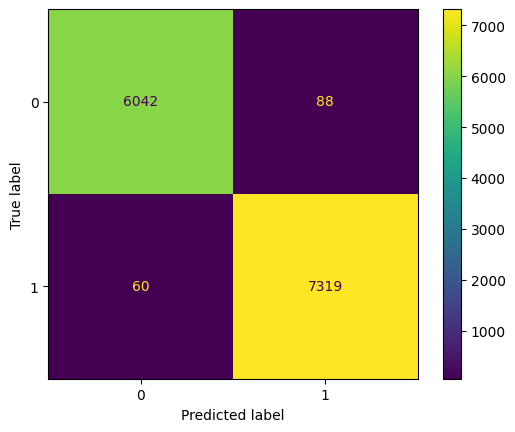

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

print(f"{pipeline.steps[-1][-1]} has an accuracy of {accuracy_score(y_test, y_pred):0.2f}")
plt.show()

# Alterative model without preprocessing

In [146]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3)

In [147]:
scores = cross_val_score(clf, X_train, y_train, cv=10)

In [148]:
print(f"{clf} has an accuracy of {scores.mean():0.2f} (standard deviation {scores.std():0.2f})")

GradientBoostingClassifier(learning_rate=1.0) has an accuracy of 0.97 (standard deviation 0.01)


# Modell mit allen Daten trainieren

In [43]:
# XXX analyse watning about integer columns and missing values
import mlflow

mlflow.set_experiment('pipeline')
mlflow.sklearn.autolog()
pipeline.fit(df.drop('class', axis='columns'), df['class'])

2024/07/06 10:03:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1050bad6599f415fa8fe5c414a259ebb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/07/06 10:03:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https:/

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('categorical',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['cap-shape', 'gill-attachment', 'gill-color', 'stem-color', 'season'], dtype='object'))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [54]:
import mlflow
logged_model = 'runs:/1050bad6599f415fa8fe5c414a259ebb/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(df.drop('class', axis='columns'))

array([1, 1, 1, ..., 1, 1, 1])

In [2]:
from mlflow import MlflowClient

client = MlflowClient()
all_experiments = client.search_experiments()

print(all_experiments)


[<Experiment: artifact_location='file:///notebooks/mlruns/580673819934877777', creation_time=1720251001082, experiment_id='580673819934877777', last_update_time=1720251001082, lifecycle_stage='active', name='MLflow Quickstart', tags={}>, <Experiment: artifact_location='file:///notebooks/mlruns/0', creation_time=1719776407530, experiment_id='0', last_update_time=1719776407530, lifecycle_stage='active', name='Default', tags={}>]
